In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git config --global user.name "alistvt"
!git config --global user.email "alistvt@gmail.com"

%cd /content/drive/MyDrive/multidoc-conv-qa/src/retriever

/content/drive/MyDrive/multidoc-conv-qa/src/retriever


In [3]:
!pip install -r ../../requirements.txt --quiet
!pip install --quiet transformers datasets accelerate

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 76 kB 6.7 MB/s 
     |████████████████████████████████| 5.8 MB 75.5 MB/s 
     |████████████████████████████████| 325 kB 91.8 MB/s 
     |████████████████████████████████| 10.6 MB 80.2 MB/s 
     |████████████████████████████████| 159 kB 75.6 MB/s 
     |████████████████████████████████| 680 kB 70.5 MB/s 
     |████████████████████████████████| 1.2 MB 65.8 MB/s 
     |████████████████████████████████| 248 kB 72.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 88.9 MB/s 
     |████████████████████████████████| 880 kB 81.0 MB/s 
     |████████████████████████████████| 7.6 MB 77.2 MB/s 
     |████████████████████████████████| 115 kB 91.8 MB/s 
     |████████████████████████████████| 212 kB 78.5 MB/s 
     |███████████████

# Document Retrival with Follow up Detector (DR.FUD) + DR. TEIT

In this method we use a FCN to detect wheter a question is a follow up of the previous question, meaning that the document is the same of not. If the document is the same, we use the previous answer's document for this question also.

We used LaBSE model for out embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

# Dataset
### Dataset Description

- **mutldoc2dial_doc.json** contains the documents that are indexed by key `domain` and `doc_id` . Each document instance includes the following,

  - `doc_id`: the ID of a document;
  - `title`: the title of the document;
  - `domain`: the domain of the document;
  - `doc_text`: the text content of the document (without HTML markups);
  - `doc_html_ts`: the document content with HTML markups and the annotated spans that are indicated by `text_id` attribute, which corresponds to `id_sp`.
  - `doc_html_raw`: the document content with HTML markups and without span annotations.
  - `spans`: key-value pairs of all spans in the document, with `id_sp` as key. Each span includes the following,
    - `id_sp`: the id of a  span as noted by `text_id` in  `doc_html_ts`;
    - `start_sp`/  `end_sp`: the start/end position of the text span in `doc_text`;
    - `text_sp`: the text content of the span.
    - `id_sec`: the id of the (sub)section (e.g. `<p>`) or title (`<h2>`) that contains the span.
    - `start_sec` / `end_sec`: the start/end position of the (sub)section in `doc_text`.
    - `text_sec`: the text of the (sub)section.
    - `title`: the title of the (sub)section.
    - `parent_titles`: the parent titles of the `title`.

- **multidoc2dial_dial_train.json** and **multidoc2dial_dial_validation.json**  contain the training and dev split of dialogue data that are indexed by key `domain` . Please note: **For test split, we only include a dummy file in this version.**

  Each dialogue instance includes the following,

  - `dial_id`: the ID of a dialogue;
  - `turns`: a list of dialogue turns. Each turn includes,
    - `turn_id`: the time order of the turn;
    - `role`: either "agent" or "user";READ
    - `da`: dialogue act;
    - `references`: a list of spans with `id_sp` ,  `label` and `doc_id`. `references` is empty if a turn is for indicating previous user query not answerable or irrelevant to the document. **Note** that labels "*precondition*"/"*solution*" are fuzzy annotations that indicate whether a span is for describing a conditional context or a solution.
    - `utterance`: the human-generated utterance based on the dialogue scene.
Downloading the training dataset:

In [4]:
import json
with open('../../dataset/multidoc2dial/v1.0/multidoc2dial_doc.json', 'r') as f:
    multidoc2dial_doc = json.load(f)

#### Extracting titles

In [5]:
titles = []
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        titles.append(doc_idx2)

#### Extracting document texts

In [6]:
doc_texts_train = []
title_to_domain = {}
title_to_text = {}
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][doc_idx1]\
                                          [doc_idx2]['doc_text'].strip())
        title_to_domain[doc_idx2] = doc_idx1
        title_to_text[doc_idx2] = multidoc2dial_doc['doc_data'][doc_idx1][doc_idx2]['doc_text'].strip()

## Encoding the sentences
We use the LaBSE which is a Language-agnostic BERT Sentence Encoder (LaBSE) is a BERT-based model trained for sentence embedding for 109 languages. The pre-training process combines masked language modeling with translation language modeling. The model is useful for getting multilingual sentence embeddings and for bi-text retrieval.

In [7]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import numpy as np
import torch
from torch.nn.functional import normalize

from tqdm import tqdm

model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/576 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

### `get_embeddings`
In this method we extract the **pooler output** (Last layer hidden-state of the first token of the sequence (classification token) after further processing through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns the classification token after processing through a linear layer and a tanh activation function. The linear layer weights are trained from the next sentence prediction (classification) objective during pretraining).

In [8]:
def get_embeddings(sentece):
    """
    Return embeddings based on encoder model

    :param sentence: input sentence(s)
    :type sentence: str or list of strs
    :return: embeddings
    """
    tokenized = tokenizer(sentece,
                                return_tensors="pt",
                                padding=True)
    with torch.no_grad():
        embeddings = model(**tokenized)
    
    return np.squeeze(np.array(embeddings.pooler_output))

### Title embedding

In [9]:
import os
title_embeddings_file = 'doc_title_LaBSE_Embedding.npy'

if not os.path.exists(title_embeddings_file):
    title_embeddings = []
    for title in tqdm(titles):
        title_embeddings.append(get_embeddings(title))

    with open(title_embeddings_file, 'wb') as f:
        np.save(f, np.array(title_embeddings))
else:
    title_embeddings = np.load(title_embeddings_file)
    title_embeddings = list(title_embeddings)


In [10]:
import pickle
title_to_embeddings_file = 'title_to_embeddings.pkl'

if not os.path.exists(title_to_embeddings_file):
    title_to_embeddings = {}
    for title in tqdm(titles):
        title_to_embeddings[title] = get_embeddings(title)
    with open(title_to_embeddings_file, 'wb') as f:
        pickle.dump(title_to_embeddings, f)
else:
    with open(title_to_embeddings_file, 'rb') as f:
        title_to_embeddings = pickle.load(f)

## Calculating the IDF for each token

In [11]:
words_idf_file = 'IDFs.pkl'
N_doc = len(doc_texts_train)

if not os.path.exists(words_idf_file):
    # First getting all distinct words in all documents
    words = set()
    doc_texts_train_tokenized = []
    for doc in tqdm(doc_texts_train, desc="getting all words from documents"):
        tokenized_doc = [s.lower() for s in tokenizer.tokenize(doc)]
        doc_texts_train_tokenized.append(tokenized_doc) 
        words = set(tokenized_doc).union(words)

    # calculating each word IDF
    words2IDF = {}
    for word in tqdm(words, desc="calculating words IDF scores"):
        n_word = 0
        for doc in doc_texts_train_tokenized:
            if word in doc:
                n_word += 1
        words2IDF[word] = np.log(N_doc / (n_word + 1))

    with open(words_idf_file, 'wb') as f:
        pickle.dump(words2IDF, f)

else:
    with open(words_idf_file, 'rb') as f:
        words2IDF = pickle.load(f)

In [12]:
len(words2IDF)

8446

In [13]:
def calc_idf_score(sentence):
    """
    Calculate the mean idf score for given sentence.
    (used to understand the contribution of the knowledge of each question
    questions with high frequent words are meaningless and we can ignore them
    roughly, which is done by this score.)

    :param sentence: input sentence
    :type sentence: str
    :return: mean idf score of sentence token
    """
    tokenzied_sentence = [s.lower() for s in tokenizer.tokenize(sentence)]
    score = 0
    for token in tokenzied_sentence:
        if token in words2IDF:
            score += words2IDF[token]
        else:
            score += np.log(N_doc)
    return score / len(tokenzied_sentence) if len(tokenzied_sentence) else 0

## Constructing the Follow-up Dataset

``` history | question | is_follow_up```

is_follow_up: shows that the history's document is the same as the current question's.

In [ ]:
def combine_sentences(s1, s2):
    separation_token = " <SEP> "
    return s1 + separation_token + s2


def construct_followup_dataset(filepath):
    import json
    with open(filepath, 'r') as f:
        multidoc2dial_dial_train = json.load(f)
    
    historys = []
    questions = []
    combined = []
    labels = []
    prev_docs = []
    current_docs = []
    prev_answers = []

    for domain in multidoc2dial_dial_train['dial_data']:
        for dial in multidoc2dial_dial_train['dial_data'][domain]:
            prev_doc = ''
            prev_question = ''
            prev_answer = ''
            for turn in dial['turns']:
                if turn['role'] == "user":
                    current_question = turn['utterance']
                    historys.append(prev_question)
                    questions.append(current_question)
                    
                    combined.append(combine_sentences(prev_question, current_question))

                    current_doc = turn['references'][0]['doc_id']
                    labels.append(int(current_doc==prev_doc))

                    prev_docs.append(prev_doc)
                    current_docs.append(current_doc)
                    prev_answers.append(prev_answer)

                    prev_doc, prev_question = current_doc, current_question
                else:
                    prev_answer = turn['utterance']
                    
    return historys, questions, combined, labels, prev_docs, current_docs, prev_answers

In [ ]:
import pandas as pd

train_history, train_questions, train_combined, train_labels, train_prev_docs, train_current_docs, train_prev_answers = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_train.json')
test_history, test_questions, test_combined, test_labels, test_prev_docs, test_current_docs, test_prev_answers = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_validation.json')

train_dict_dataset = {"history":train_history, "question": train_questions, "combined": train_combined, "followup": train_labels, "prev_doc": train_prev_docs, "current_doc": train_current_docs, "prev_answer": train_prev_answers}
test_dict_dataset = {"history":test_history, "question": test_questions, "combined": test_combined, "followup": test_labels, "prev_doc": test_prev_docs, "current_doc": test_current_docs, "prev_answer": test_prev_answers}

train_df = pd.DataFrame(train_dict_dataset)
test_df = pd.DataFrame(test_dict_dataset)

In [ ]:
max([len(x["combined"].split()) for _, x in test_df.iterrows()])

74

In [ ]:
train_df

,history,question,combined,followup,prev_doc,current_doc,prev_answer
0,,"Hello, I forgot o update my address, can you h...","<SEP> Hello, I forgot o update my address, ca...",0,,Top 5 DMV Mistakes and How to Avoid Them#3_0,
1,"Hello, I forgot o update my address, can you h...",Can I do my DMV transactions online?,"Hello, I forgot o update my address, can you h...",1,Top 5 DMV Mistakes and How to Avoid Them#3_0,Top 5 DMV Mistakes and How to Avoid Them#3_0,"hi, you have to report any change of address t..."
2,Can I do my DMV transactions online?,You've got it. Another query about DMV. What h...,Can I do my DMV transactions online? <SEP> You...,0,Top 5 DMV Mistakes and How to Avoid Them#3_0,Registration suspensions for failure to pay to...,"Yes, you can sign up for MyDMV for all the onl..."
3,You've got it. Another query about DMV. What h...,"Besides that, will I receive a notice?",You've got it. Another query about DMV. What h...,1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...,the suspension is placed on hold pending the o...
4,"Besides that, will I receive a notice?",If you submit the affidavit?,"Besides that, will I receive a notice? <SEP> I...",1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...,"the NYS Department of Motor Vehicles , "" DMV ..."
...,...,...,...,...,...,...,...
23394,"By the way, who can I contact to give me infor...",What if I've fallen behind on one or more loan...,"By the way, who can I contact to give me infor...",0,Loan Servicers | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,Your school's financial aid office must have t...
23395,What if I've fallen behind on one or more loan...,I have another question regarding the Military...,What if I've fallen behind on one or more loan...,0,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Deferment | Federal Student Aid#1_0,One thing you definitely want to avoid is goin...
23396,I have another question regarding the Military...,something else I want to ask about FAFSA. What...,I have another question regarding the Military...,0,Student Loan Deferment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,You will have to complete the Military Service...
23397,something else I want to ask about FAFSA. What...,How can I make a payment by post?,something else I want to ask about FAFSA. What...,1,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,contact your loan servicer to find out your op...


In [ ]:
def tokenize_function(examples, prediction=False, cuda=False):
    if prediction:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    else:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True)
    if cuda:
        tokenized_cuda = {}
        for key, value in tokenized.items():
            tokenized_cuda[key] = value.cuda()
        return tokenized_cuda
    else:
        return tokenized

### constructing dataloader

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenized_trainset = train_dataset.map(tokenize_function, batched=True)
tokenized_testset = test_dataset.map(tokenize_function, batched=True)

tokenized_trainset = tokenized_trainset.rename_column("followup", "label")
tokenized_testset = tokenized_testset.rename_column("followup", "label")

fud_dataset = DatasetDict()

fud_dataset['train'] = tokenized_trainset
fud_dataset['validation'] = tokenized_testset


  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

# Methods

## FCN based on [cls]

### AutoModelForSequenceClassification

We use a classification method on the questions to decide the relationship between the previous question and current question.
In the dataset provided to us, previous turn documents are predefined, meaning that we are aware of the previous documents, therefore, if the prediction predicts that current question's document is the same as the previous, we don't need to retrieve a document and we give the previous doc_id.

#### model

In [14]:
tokenizer_name = "setu4993/LaBSE"
model_name = "alistvt/fudnet"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
fudnet_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda:0")
fudnet_model.to(device)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(501153, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

#### metrics

In [15]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### train

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='/home/',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy ='epoch',
    load_best_model_at_end=True,
    # auto_find_batch_size=True,
)

trainer = Trainer(
    model=fudnet_model,
    args=training_args,
    train_dataset=fud_dataset['train'],
    eval_dataset=fud_dataset['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23399
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1464


Epoch,Training Loss,Validation Loss,Accuracy
1,0.172100,0.144127,0.949066
2,0.094800,0.137107,0.954404


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4496
  Batch size = 32
Saving model checkpoint to /home/checkpoint-732
Configuration saved in /home/checkpoint-732/config.json
Model weights saved in /home/checkpoint-732/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Run

TrainOutput(global_step=1464, training_loss=0.1559999535481135, metrics={'train_runtime': 779.0272, 'train_samples_per_second': 60.072, 'train_steps_per_second': 1.879, 'total_flos': 3078267792184320.0, 'train_loss': 0.1559999535481135, 'epoch': 2.0})

### DR. TEIT*

In this method we used two scoring measure and aggregate them by a convex combination as below:
$$
λ*Similiarity_{Title Embedding} + (1-λ)*Similiarity_{TextIDF}
$$

We used LaBSE model for our embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

For the second part we used character-level (2gram to 8gram). We also trained our TF-IDF transformation matrix on the Multidoc2dial2022 documnets.

**NOTE: In `predict_DR_TEIT` you may see a diffrent notation (`alpha`) but they are the same.**

#### TF-IDF Transformation Matrix Fitting

In [ ]:
doc_texts_train = []
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][doc_idx1]\
                                          [doc_idx2]['doc_text'].strip())

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(strip_accents=None,
                                 analyzer='char',
                                 ngram_range=(2, 8),
                                 norm='l2',
                                 use_idf=True,
                                 smooth_idf=True)
tfidf_wm = tfidfVectorizer.fit_transform(doc_texts_train)

In [ ]:
import pickle
with open('tfidfVectorizer.pkl', 'wb') as f:
    pickle.dump(tfidfVectorizer, f)

with open('tfidf_wm.pkl', 'wb') as f:
    pickle.dump(tfidf_wm, f)

In [ ]:
len(tfidfVectorizer.get_feature_names_out())

1047632

#### DR. TEIT

the input is consisted of a list of queries, which is the current question and its history turns.
for each of the questions, we compute two similarity score for each of our documents, one of them is based on the pretrained LM and the other on is based on character level matching. Both of these scores will be weighted by a coefficient which is the `idf_score` of the query, defining how much meaning does the query contain. Then these scores will be summed up in a convex manner and the final matching score with all documents is computed. We return the result by sorting these scores.

In [ ]:
def predict_DR_TEIT(queries, k=1, alpha=10):
    """
    Predict which document is matched to the given query.

    :param queries: input queries in time reversed order (latest first)
    :type queries: str (or list of strs)
    :param k: number of returning docs
    :type k: int 
    :return: return the document names and accuracies
    """

    idf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    tfidf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    coef_sum = 0
    for i, query in enumerate(queries):
        query_embd = get_embeddings(query)
        query_sim = list(map(lambda x: np.dot(x, query_embd) /
                            (np.linalg.norm(query_embd) * np.linalg.norm(x)),
                            title_embeddings))
        query_sim = np.array(query_sim)
        # coef = 2**(-i) * calc_idf_score(query)
        coef = calc_idf_score(query)
        coef_sum += coef

        idf_score += coef * query_sim
        tfidf_score += coef * np.squeeze(np.asarray(tfidf_wm @ tfidfVectorizer.transform([query]).todense().T))

    scores = (idf_score + alpha * tfidf_score) / coef_sum
    best_k_idx = scores.argsort()[::-1][:k]
    scores = scores[best_k_idx]
    predictions = list(map(lambda x: titles[x], best_k_idx))
    return (scores, predictions)

### FUDNet + DR. TEIT

In [16]:
def predict_FUDNet_DR_TEIT(data, k=1):
    inputs = tokenize_function(data, prediction=True, cuda=True)
    outputs = fudnet_model(**inputs)
    is_followup = bool(torch.argmax(outputs.logits))
    
    if is_followup:
        dr_scores, dr_predictions = predict_DR_TEIT([data['prev_answer'], data['question'], data['history']], k=k)
        return dr_predictions
    else:
        dr_scores, dr_predictions = predict_DR_TEIT([data['question']], k=k)
        return dr_predictions

In [ ]:
test_df.loc[2]

history                         Don't do that I'll get insurance
question       I have, that is why I am here to clear that up...
combined       Don't do that I'll get insurance <SEP> I have,...
followup                                                       1
prev_doc            Top 5 DMV Mistakes and How to Avoid Them#3_0
current_doc         Top 5 DMV Mistakes and How to Avoid Them#3_0
prev_answer    Okay, have you received a letter from the DMV ...
Name: 2, dtype: object

In [ ]:
predict_FUDNet_DR_TEIT(test_df.loc[2], k=5)

['Top 5 DMV Mistakes and How to Avoid Them#3_0',
 'Respond to DMV insurance letters and orders#3_0',
 'How to change your address#1_0',
 'Insurance lapses#3_0',
 'Information about transaction entries#3_0']

## Unknown Prediction
here we train a Classifier to get a question and a document and predict wether the question can be answered with respect to the document.

### Constructing Unknown detection Dataset
we construct a dataset that gets the history and selected documents. The documents are retrieved from the `Dr_Fud_Dr_Teit` Predictor and we choose the first 3 of them and for each of them we give a label: 0 means unanswerable and 1 means answerable.

In [17]:
def combine_history_and_doc(history, doc):
    separation_token = " <SEP> "
    return history + separation_token + doc


def construct_unknown_dataset(filepath):
    import json
    with open(filepath, 'r') as f:
        multidoc2dial_dial_train = json.load(f)
    
    historys = []
    doc_ids = []
    labels = []

    for domain in multidoc2dial_dial_train['dial_data']:
        for dial in tqdm(multidoc2dial_dial_train['dial_data'][domain], desc=f"processing domain {domain}"):
            prev_question = ''
            prev_answer = ''
            for turn in dial['turns']:
                if turn['role'] == "user":
                    current_question = turn['utterance']
                    combined = combine_sentences(prev_question, current_question)

                    inputs = tokenize_function({'combined': combined}, prediction=True, cuda=True)
                    outputs = fudnet_model(**inputs)
                    is_followup = bool(torch.argmax(outputs.logits))
                    
                    if is_followup:
                        history = [prev_answer, current_question, prev_question]
                        history_str = " ".join(history).strip()
                        dr_scores, dr_predictions = predict_DR_TEIT(history, k=3)
                    else:
                        history = [current_question]
                        history_str = history[0].strip()
                        dr_scores, dr_predictions = predict_DR_TEIT(history, k=3)

                    current_doc_id = turn['references'][0]['doc_id']
                    dr_predictions.append(current_doc_id)
                    doc_id_predictions = list(set(dr_predictions))

                    for doc_id in doc_id_predictions:
                        historys.append(history_str)
                        doc_ids.append(doc_id)
                        labels.append(doc_id == current_doc_id)

                    prev_question = current_question
                else:
                    prev_answer = turn['utterance']
                    
    return historys, doc_ids, labels

In [18]:
import pandas as pd

if not os.path.exists("notebooks/train_unknown_df.json"):
    train_history, train_doc_ids, train_labels = construct_unknown_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_train.json')
    test_history, test_doc_ids, test_labels = construct_unknown_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_validation.json')

    train_doc_texts = [title_to_text[title] for title in train_doc_ids]
    test_doc_texts = [title_to_text[title] for title in test_doc_ids]

    train_combined = [combine_history_and_doc(_history, _doc_text) for _history, _doc_text in zip(train_history, train_doc_texts)]
    test_combined = [combine_history_and_doc(_history, _doc_text) for _history, _doc_text in zip(test_history, test_doc_texts)]

    train_unknown_df = pd.DataFrame({
        'history': train_history,
        'doc_text': train_doc_texts,
        'combined': train_combined,
        'label': train_labels
    })
    test_unknown_df = pd.DataFrame({
        'history': test_history,
        'doc_text': test_doc_texts,
        'combined': test_combined,
        'label': test_labels
    })
    
    with open("notebooks/train_unknown_df.json", 'w', encoding="utf-8") as f:
        train_unknown_df.to_json(f)
    with open("notebooks/test_unknown_df.json", 'w', encoding="utf-8") as f:
        test_unknown_df.to_json(f)
else:
    train_unknown_df = pd.read_json("notebooks/train_unknown_df.json")
    test_unknown_df = pd.read_json("notebooks/test_unknown_df.json")
    


In [19]:
s = []
total = 0
for doc in title_to_text.values():
    s.append(len(doc.split()))

import numpy as np

#calculate standard deviation of list
print(np.mean(s))
print(np.std(s))

len(train_unknown_df.loc[train_unknown_df['label'] == True])/len(train_unknown_df.loc[train_unknown_df['label'] == False])

828.3852459016393
624.3178434246311


0.4357923751699477

In [20]:

s = []
total = 0
for doc in train_unknown_df['history']:
    s.append(len(doc.split()))

import numpy as np

#calculate standard deviation of list
print(np.mean(s))
print(np.std(s))

len(train_unknown_df.loc[train_unknown_df['label'] == True])/len(train_unknown_df.loc[train_unknown_df['label'] == False])

30.910898666528304
17.90193085542348


0.4357923751699477

In [23]:
!git status

On branch concat-documents
Your branch is up to date with 'origin/concat-documents'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	IDFs.pkl
	doc_title_LaBSE_Embedding.npy
	notebooks/DR_FUD_Unknown.ipynb
	notebooks/test_unknown_df.json
	notebooks/train_unknown_df.json
	tfidfVectorizer.pkl
	tfidf_wm.pkl
	title_to_embeddings.pkl

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
def tokenize_function(examples, prediction=False, cuda=False):
    if prediction:
        tokenized = tokenizer(examples['combined'], max_length=512, padding="max_length", truncation=True, return_tensors='pt')
    else:
        tokenized = tokenizer(examples['combined'], max_length=512, padding="max_length", truncation=True)
    if cuda:
        tokenized_cuda = {}
        for key, value in tokenized.items():
            tokenized_cuda[key] = value.cuda()
        return tokenized_cuda
    else:
        return tokenized

In [29]:
from datasets import Dataset, DatasetDict

train_unknown_dataset = Dataset.from_pandas(train_unknown_df)
test_unknown_dataset = Dataset.from_pandas(test_unknown_df)

tokenized_unknown_trainset = train_unknown_dataset.map(tokenize_function, batched=True)
tokenized_unknown_testset = test_unknown_dataset.map(tokenize_function, batched=True)

unknown_dataset = DatasetDict()

unknown_dataset['train'] = tokenized_unknown_trainset
unknown_dataset['validation'] = tokenized_unknown_testset


NameError: ignored

### Model and Training

In [ ]:
tokenizer_name = "setu4993/LaBSE"
model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
unknown_predictor_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda:0")
unknown_predictor_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at setu4993/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(501153, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='/home/',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy ='epoch',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=unknown_predictor_model,
    args=training_args,
    train_dataset=unknown_dataset['train'],
    eval_dataset=unknown_dataset['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, doc_text, history, combined. If __index_level_0__, doc_text, history, combined are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 77092
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7230


Epoch,Training Loss,Validation Loss,Accuracy
1,0.476600,0.539866,0.751931
2,0.357600,0.647489,0.759522
3,0.311700,0.715940,0.769060


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, doc_text, history, combined. If __index_level_0__, doc_text, history, combined are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 14887
  Batch size = 32
Saving model checkpoint to /home/checkpoint-2410
Configuration saved in /home/checkpoint-2410/config.json
Model weights saved in /home/checkpoint-2410/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, doc_text, history, combined. If __index_level_0__, doc_text, history, combined are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 14887
  Batch size = 32
S

Epoch,Training Loss,Validation Loss,Accuracy
1,0.476600,0.539866,0.751931
2,0.357600,0.647489,0.759522
3,0.311700,0.715940,0.769060


TrainOutput(global_step=7230, training_loss=0.43026860634156117, metrics={'train_runtime': 5824.2599, 'train_samples_per_second': 39.709, 'train_steps_per_second': 1.241, 'total_flos': 6.085127243943936e+16, 'train_loss': 0.43026860634156117, 'epoch': 3.0})

# Test
In the test dataset we just picked ones with **user** turn.

In [ ]:
def test_loop(df, predictor):
    prec_at_50 = 0
    prec_at_10 = 0
    prec_at_5 = 0
    prec_at_3 = 0
    prec_at_1 = 0
    ranks = []
    for index, data in tqdm(df.iterrows()):
        predictions = predictor(data, k=500)
        actual_doc = data['current_doc']
        ranks.append(1 / (predictions.index(actual_doc) + 1))
        if actual_doc == predictions[0]:
            prec_at_1 += 1
        if actual_doc in predictions[:3]:
            prec_at_3 += 1
        if actual_doc in predictions[:5]:
            prec_at_5 += 1
        if actual_doc in predictions[:10]:
            prec_at_10 += 1
        if actual_doc in predictions[:50]:
            prec_at_50 += 1

        if index % 100 == 99:
            print(f"""
                MRR: mean={np.array(ranks).mean()}, var={np.array(ranks).var()}
                Prec@(1) = {prec_at_1 / index}
                Prec@(3) = {prec_at_3 / index}
                Prec@(5) = {prec_at_5 / index}
                Prec@(10) = {prec_at_10 / index}
                Prec@(50) = {prec_at_50 / index}
                NUMBER_OF_SAMPLES = {index}
            """)

    return f"""
        MRR: mean={np.array(ranks).mean()}, var={np.array(ranks).var()}
        Prec@(1) = {prec_at_1 / index}
        Prec@(3) = {prec_at_3 / index}
        Prec@(5) = {prec_at_5 / index}
        Prec@(10) = {prec_at_10 / index}
        Prec@(50) = {prec_at_50 / index}
        NUMBER_OF_SAMPLES = {index}
    """

In [ ]:
print(test_loop(train_df, predict_FUDNet_DR_TEIT))

100it [00:55,  2.53it/s]


                MRR: mean=0.7039079215980597, var=0.14377394068348706
                Prec@(1) = 0.6060606060606061
                Prec@(3) = 0.7575757575757576
                Prec@(5) = 0.8181818181818182
                Prec@(10) = 0.9292929292929293
                Prec@(50) = 1.0
                NUMBER_OF_SAMPLES = 99
            


200it [01:57,  1.97it/s]


                MRR: mean=0.7902209363599058, var=0.11812314929333972
                Prec@(1) = 0.7135678391959799
                Prec@(3) = 0.8492462311557789
                Prec@(5) = 0.8793969849246231
                Prec@(10) = 0.9346733668341709
                Prec@(50) = 0.9899497487437185
                NUMBER_OF_SAMPLES = 199
            


300it [03:00,  1.45it/s]


                MRR: mean=0.7867803098563075, var=0.11421799672230108
                Prec@(1) = 0.6956521739130435
                Prec@(3) = 0.8595317725752508
                Prec@(5) = 0.8929765886287625
                Prec@(10) = 0.9331103678929766
                Prec@(50) = 0.9866220735785953
                NUMBER_OF_SAMPLES = 299
            


400it [03:58,  1.91it/s]


                MRR: mean=0.7874319412514239, var=0.11441718060672462
                Prec@(1) = 0.6967418546365914
                Prec@(3) = 0.8571428571428571
                Prec@(5) = 0.899749373433584
                Prec@(10) = 0.9323308270676691
                Prec@(50) = 0.9799498746867168
                NUMBER_OF_SAMPLES = 399
            


501it [04:45,  3.00it/s]


                MRR: mean=0.7901449781945575, var=0.11017359938724726
                Prec@(1) = 0.6933867735470942
                Prec@(3) = 0.8697394789579158
                Prec@(5) = 0.9078156312625251
                Prec@(10) = 0.9378757515030061
                Prec@(50) = 0.9819639278557114
                NUMBER_OF_SAMPLES = 499
            


600it [05:31,  2.00it/s]


                MRR: mean=0.7897473916759583, var=0.10947635696873903
                Prec@(1) = 0.6911519198664441
                Prec@(3) = 0.8697829716193656
                Prec@(5) = 0.9081803005008348
                Prec@(10) = 0.9382303839732888
                Prec@(50) = 0.9833055091819699
                NUMBER_OF_SAMPLES = 599
            


700it [06:30,  2.25it/s]


                MRR: mean=0.7726096881167444, var=0.1167908104255042
                Prec@(1) = 0.670958512160229
                Prec@(3) = 0.8555078683834049
                Prec@(5) = 0.8969957081545065
                Prec@(10) = 0.9284692417739628
                Prec@(50) = 0.9785407725321889
                NUMBER_OF_SAMPLES = 699
            


800it [07:14,  2.05it/s]


                MRR: mean=0.7649304655685384, var=0.12250992626019358
                Prec@(1) = 0.6670838548185232
                Prec@(3) = 0.8410513141426783
                Prec@(5) = 0.8823529411764706
                Prec@(10) = 0.9224030037546934
                Prec@(50) = 0.9737171464330413
                NUMBER_OF_SAMPLES = 799
            


900it [07:58,  2.11it/s]


                MRR: mean=0.7625521208615919, var=0.12496102112342923
                Prec@(1) = 0.6674082313681868
                Prec@(3) = 0.8364849833147943
                Prec@(5) = 0.8776418242491657
                Prec@(10) = 0.917686318131257
                Prec@(50) = 0.9699666295884316
                NUMBER_OF_SAMPLES = 899
            


1000it [08:42,  2.31it/s]


                MRR: mean=0.7598912916469895, var=0.12665441140332098
                Prec@(1) = 0.6656656656656657
                Prec@(3) = 0.8328328328328328
                Prec@(5) = 0.8738738738738738
                Prec@(10) = 0.914914914914915
                Prec@(50) = 0.96996996996997
                NUMBER_OF_SAMPLES = 999
            


1100it [09:23,  2.48it/s]


                MRR: mean=0.7614785252607713, var=0.1285055089882269
                Prec@(1) = 0.6724294813466788
                Prec@(3) = 0.8289353958143767
                Prec@(5) = 0.8698817106460418
                Prec@(10) = 0.910828025477707
                Prec@(50) = 0.9681528662420382
                NUMBER_OF_SAMPLES = 1099
            


1200it [10:06,  2.36it/s]


                MRR: mean=0.7538556721574035, var=0.12990768801222546
                Prec@(1) = 0.6605504587155964
                Prec@(3) = 0.8256880733944955
                Prec@(5) = 0.8707256046705588
                Prec@(10) = 0.9107589658048374
                Prec@(50) = 0.9658048373644704
                NUMBER_OF_SAMPLES = 1199
            


1300it [10:49,  2.03it/s]


                MRR: mean=0.7542757415017165, var=0.13174692449725176
                Prec@(1) = 0.6643571978444958
                Prec@(3) = 0.8229407236335643
                Prec@(5) = 0.8668206312548113
                Prec@(10) = 0.9045419553502695
                Prec@(50) = 0.9599692070823711
                NUMBER_OF_SAMPLES = 1299
            


1400it [11:37,  2.10it/s]


                MRR: mean=0.7395792539749166, var=0.1363833477441674
                Prec@(1) = 0.6454610436025733
                Prec@(3) = 0.810578984989278
                Prec@(5) = 0.8598999285203717
                Prec@(10) = 0.8970693352394568
                Prec@(50) = 0.9571122230164403
                NUMBER_OF_SAMPLES = 1399
            


1500it [12:30,  1.63it/s]


                MRR: mean=0.7273122061214577, var=0.13930728333936773
                Prec@(1) = 0.6290860573715811
                Prec@(3) = 0.8012008005336891
                Prec@(5) = 0.8539026017344896
                Prec@(10) = 0.895930620413609
                Prec@(50) = 0.9566377585056705
                NUMBER_OF_SAMPLES = 1499
            


1600it [13:24,  2.60it/s]


                MRR: mean=0.7313878083248604, var=0.13757780841499487
                Prec@(1) = 0.632895559724828
                Prec@(3) = 0.8061288305190745
                Prec@(5) = 0.8574108818011257
                Prec@(10) = 0.8986866791744841
                Prec@(50) = 0.9568480300187617
                NUMBER_OF_SAMPLES = 1599
            


1701it [14:03,  3.64it/s]


                MRR: mean=0.7332622077785046, var=0.13846236040586785
                Prec@(1) = 0.6380223660977046
                Prec@(3) = 0.8034137728075338
                Prec@(5) = 0.8552089464390819
                Prec@(10) = 0.8964096527369041
                Prec@(50) = 0.9540906415538553
                NUMBER_OF_SAMPLES = 1699
            


1800it [14:51,  1.48it/s]


                MRR: mean=0.7340036235924584, var=0.1380606571346907
                Prec@(1) = 0.6386881600889383
                Prec@(3) = 0.8037798777098388
                Prec@(5) = 0.8560311284046692
                Prec@(10) = 0.896609227348527
                Prec@(50) = 0.9560867148415787
                NUMBER_OF_SAMPLES = 1799
            


1900it [15:34,  2.64it/s]


                MRR: mean=0.7330712905388772, var=0.13852601920689336
                Prec@(1) = 0.6377040547656662
                Prec@(3) = 0.8020010531858873
                Prec@(5) = 0.8530805687203792
                Prec@(10) = 0.8962611901000527
                Prec@(50) = 0.956292785676672
                NUMBER_OF_SAMPLES = 1899
            


2000it [16:11,  2.79it/s]


                MRR: mean=0.7320744715455726, var=0.13834577876986093
                Prec@(1) = 0.6353176588294147
                Prec@(3) = 0.8029014507253627
                Prec@(5) = 0.8529264632316158
                Prec@(10) = 0.8959479739869936
                Prec@(50) = 0.9569784892446224
                NUMBER_OF_SAMPLES = 1999
            


2101it [16:52,  2.93it/s]


                MRR: mean=0.7283306867856705, var=0.1392562010541808
                Prec@(1) = 0.6303001429252024
                Prec@(3) = 0.7984754645069081
                Prec@(5) = 0.851357789423535
                Prec@(10) = 0.8951881848499286
                Prec@(50) = 0.9575988565983802
                NUMBER_OF_SAMPLES = 2099
            


2200it [17:31,  2.49it/s]


                MRR: mean=0.7246800431670232, var=0.1404764282528079
                Prec@(1) = 0.626193724420191
                Prec@(3) = 0.7953615279672579
                Prec@(5) = 0.848112778535698
                Prec@(10) = 0.8926784902228285
                Prec@(50) = 0.956343792633015
                NUMBER_OF_SAMPLES = 2199
            


2300it [18:10,  2.33it/s]


                MRR: mean=0.7203189365537066, var=0.14111042084852912
                Prec@(1) = 0.6198347107438017
                Prec@(3) = 0.7929534580252283
                Prec@(5) = 0.8477598956067856
                Prec@(10) = 0.8925619834710744
                Prec@(50) = 0.9560678555893867
                NUMBER_OF_SAMPLES = 2299
            


2401it [18:50,  2.75it/s]


                MRR: mean=0.717647177760092, var=0.14124431538180318
                Prec@(1) = 0.6148395164651939
                Prec@(3) = 0.7936640266777825
                Prec@(5) = 0.8470195914964569
                Prec@(10) = 0.8912046686119216
                Prec@(50) = 0.9537307211338057
                NUMBER_OF_SAMPLES = 2399
            


2500it [19:29,  2.45it/s]


                MRR: mean=0.7220643404131545, var=0.1404006902924593
                Prec@(1) = 0.6210484193677471
                Prec@(3) = 0.79671868747499
                Prec@(5) = 0.8495398159263705
                Prec@(10) = 0.8923569427771109
                Prec@(50) = 0.9535814325730292
                NUMBER_OF_SAMPLES = 2499
            


2600it [20:16,  2.59it/s]


                MRR: mean=0.7232805936274715, var=0.14015997061132265
                Prec@(1) = 0.6225471335128896
                Prec@(3) = 0.7983839938437861
                Prec@(5) = 0.850327048864948
                Prec@(10) = 0.8918814928818777
                Prec@(50) = 0.9522893420546364
                NUMBER_OF_SAMPLES = 2599
            


2701it [20:56,  2.73it/s]


                MRR: mean=0.7224512168345909, var=0.13989230430130203
                Prec@(1) = 0.6206002223045572
                Prec@(3) = 0.7980733605038903
                Prec@(5) = 0.8510559466469063
                Prec@(10) = 0.8936643201185624
                Prec@(50) = 0.9525750277880697
                NUMBER_OF_SAMPLES = 2699
            


2801it [21:36,  2.93it/s]


                MRR: mean=0.723284512200846, var=0.1395525968408766
                Prec@(1) = 0.6216505894962486
                Prec@(3) = 0.7988567345480528
                Prec@(5) = 0.8524473026080743
                Prec@(10) = 0.894962486602358
                Prec@(50) = 0.9531975705609146
                NUMBER_OF_SAMPLES = 2799
            


2900it [22:16,  2.85it/s]


                MRR: mean=0.7277695589471972, var=0.138023866415364
                Prec@(1) = 0.6267678509830976
                Prec@(3) = 0.8040703690927906
                Prec@(5) = 0.8558123490858917
                Prec@(10) = 0.8975508796136599
                Prec@(50) = 0.9541221110727838
                NUMBER_OF_SAMPLES = 2899
            


3000it [23:03,  1.98it/s]


                MRR: mean=0.7269322583737823, var=0.13798928038796876
                Prec@(1) = 0.6252084028009336
                Prec@(3) = 0.804268089363121
                Prec@(5) = 0.8559519839946649
                Prec@(10) = 0.8979659886628877
                Prec@(50) = 0.9539846615538513
                NUMBER_OF_SAMPLES = 2999
            


3101it [23:50,  2.85it/s]


                MRR: mean=0.7227207931185224, var=0.1390324738244245
                Prec@(1) = 0.6195546950629235
                Prec@(3) = 0.8005808325266215
                Prec@(5) = 0.8538238141335914
                Prec@(10) = 0.8967408841561794
                Prec@(50) = 0.952242658922233
                NUMBER_OF_SAMPLES = 3099
            


3200it [24:45,  1.22it/s]


                MRR: mean=0.7177462242327078, var=0.13976990158239178
                Prec@(1) = 0.6123788683963739
                Prec@(3) = 0.795873710534542
                Prec@(5) = 0.8540168802750859
                Prec@(10) = 0.8968427633635511
                Prec@(50) = 0.9524851516098781
                NUMBER_OF_SAMPLES = 3199
            


3300it [25:34,  2.00it/s]


                MRR: mean=0.7191055787126427, var=0.13951375786250292
                Prec@(1) = 0.6141254925735071
                Prec@(3) = 0.7975143983025159
                Prec@(5) = 0.854501364049712
                Prec@(10) = 0.8966353440436496
                Prec@(50) = 0.9518035768414671
                NUMBER_OF_SAMPLES = 3299
            


3400it [26:29,  1.56it/s]


                MRR: mean=0.7187689758443021, var=0.13970566024557987
                Prec@(1) = 0.6137099146807885
                Prec@(3) = 0.7969991173874669
                Prec@(5) = 0.8531921153280376
                Prec@(10) = 0.8955575169167402
                Prec@(50) = 0.9514563106796117
                NUMBER_OF_SAMPLES = 3399
            


3501it [27:12,  2.79it/s]


                MRR: mean=0.7148892586937194, var=0.14063257461076012
                Prec@(1) = 0.6084595598742498
                Prec@(3) = 0.7945127179194056
                Prec@(5) = 0.8499571306087453
                Prec@(10) = 0.8933981137467848
                Prec@(50) = 0.9505573020863104
                NUMBER_OF_SAMPLES = 3499
            


3600it [27:56,  2.12it/s]


                MRR: mean=0.7124572679806125, var=0.1404772117604505
                Prec@(1) = 0.60377882745207
                Prec@(3) = 0.7949430397332592
                Prec@(5) = 0.8505140316754654
                Prec@(10) = 0.8938594053903862
                Prec@(50) = 0.9505418171714365
                NUMBER_OF_SAMPLES = 3599
            


3700it [28:38,  2.34it/s]


                MRR: mean=0.7104183314076932, var=0.14120532151596038
                Prec@(1) = 0.6017842660178426
                Prec@(3) = 0.7923763179237632
                Prec@(5) = 0.8486077318194106
                Prec@(10) = 0.8932143822654771
                Prec@(50) = 0.9510678561773452
                NUMBER_OF_SAMPLES = 3699
            


3800it [29:22,  1.61it/s]


                MRR: mean=0.7118527162483748, var=0.14108700928824341
                Prec@(1) = 0.6041063437746775
                Prec@(3) = 0.7933666754409056
                Prec@(5) = 0.8486443801000263
                Prec@(10) = 0.8933929981574098
                Prec@(50) = 0.951302974466965
                NUMBER_OF_SAMPLES = 3799
            


3900it [30:18,  3.39it/s]


                MRR: mean=0.7068083290028647, var=0.142900459786548
                Prec@(1) = 0.5988715055142344
                Prec@(3) = 0.7873813798409849
                Prec@(5) = 0.8435496281097717
                Prec@(10) = 0.8897153116183637
                Prec@(50) = 0.951013080276994
                NUMBER_OF_SAMPLES = 3899
            


4000it [31:12,  1.89it/s]


                MRR: mean=0.7087228867912012, var=0.14229687392919907
                Prec@(1) = 0.6009002250562641
                Prec@(3) = 0.7891972993248312
                Prec@(5) = 0.8452113028257064
                Prec@(10) = 0.8904726181545386
                Prec@(50) = 0.9509877469367342
                NUMBER_OF_SAMPLES = 3999
            


4100it [32:14,  2.30it/s]


                MRR: mean=0.7078666251498227, var=0.14220498192120987
                Prec@(1) = 0.599170529397414
                Prec@(3) = 0.7892168821663821
                Prec@(5) = 0.8455720907538424
                Prec@(10) = 0.8907050500121981
                Prec@(50) = 0.9509636496706514
                NUMBER_OF_SAMPLES = 4099
            


4201it [32:58,  2.68it/s]


                MRR: mean=0.7083708545360687, var=0.1422090041168014
                Prec@(1) = 0.600142891164563
                Prec@(3) = 0.7894736842105263
                Prec@(5) = 0.8452012383900929
                Prec@(10) = 0.8911645629911884
                Prec@(50) = 0.9511788521076446
                NUMBER_OF_SAMPLES = 4199
            


4300it [33:52,  2.19it/s]


                MRR: mean=0.7090700783203909, var=0.1425318346411204
                Prec@(1) = 0.6020004652244708
                Prec@(3) = 0.7887880902535473
                Prec@(5) = 0.8436845778087927
                Prec@(10) = 0.8909048615957199
                Prec@(50) = 0.9506862060944405
                NUMBER_OF_SAMPLES = 4299
            


4340it [34:07,  2.12it/s]


KeyboardInterrupt: ignored

In [ ]:
print(test_loop(train_df, predict_KNN_FUDNet_DR_TEIT))

# Results

At last we have resutls as follows:


| Method | @1 | @5 | @10 | @50 | @100 | MRR (mean, var) |
|:------:|:------:|:------:|:-------:|:-------:|:--------:|:---:|
| IDF - vanilla | 13% | 30% | 39% | 64% | 83% | (0.22, 0.11) |
| IDF - power-order | 15% | 31% | 41% | 65% | 83% | (0.23, 0.12) |
| IDF - power-order (softmax) | 10.7% | 23% | 31% | 57.6% | 78% | (0.18, 0.09) |
| IDF - self-attention | 13.9% | 29% | 38% | 62% | 82% | (0.22, 0.11) |
| DR. TEIT | 61.6% | 86% | 91% | 96% | 98% | (0.72, 0.13) |
| DR. TEIT (val) | 40.0% | 69.25% | 92.4% | 99% | 98% | (0.53, 0.16) |
| FUDNet + DR. TEIT | 67% | 87% | 91% | 96% | 99% | (0.76, 0.12) |
| FUDNet + DR. TEIT (val) | 48.2% | 75.48% | 82% | 93% | 99% | (0.60, 0.16) |

MRR: mean=0.7605851824924286, var=0.12850709866222307
                Prec@(1) = 0.6706096451319381
                Prec@(5) = 0.8698817106460418
                Prec@(10) = 0.910828025477707
                Prec@(50) = 0.9681528662420382
                NUMBER_OF_SAMPLES = 1099

# drafts

In [ ]:
def simple_fudnet_test():
  data = {"combined": " <SEP> Hello. how can you help me?", "label": 0}
  inputs = tokenize_function(data, prediction=True, cuda=True)
  labels = torch.tensor([data['label']]).unsqueeze(0)  # Batch size 1
  outputs = fudnet_model(**inputs)
  prediction = torch.argmax(outputs.logits)
  print(prediction)

simple_test()

In [ ]:
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5EncoderModel
import torch

model_name = ["setu4993/LaBSE", "t5-small", "bert-base-uncased"][0]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenizer = T5Tokenizer.from_pretrained("t5-base")
# model = T5EncoderModel.from_pretrained("t5-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print("inputs", inputs)

print("last_hidden_states", last_hidden_states.shape)

# pooler = outputs.pooler_output
# print("pooler",pooler.shape)
# with torch.no_grad():
#     print(np.squeeze(np.array(pooler)).shape)

In [ ]:
import numpy as np

from utils import scaled_dot_product_attention

inputs = tokenizer(["Hello, my dog is cute", "Yes this is a beautiful dog and you can have it."], max_length=16, padding="max_length", return_tensors="pt")
outputs = model(**inputs)

query=last_hidden_states[0, :, :]
key=last_hidden_states[1, :, :]
value=last_hidden_states[1, :, :]

context, attention = scaled_dot_product_attention(
    query=query,
    key=key,
    value=value,
)

In [ ]:
context.shape , attention.shape

(torch.Size([16, 768]), torch.Size([16, 16]))

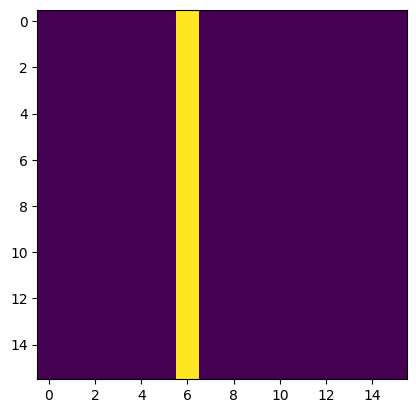

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    plt.imshow(attention, interpolation='nearest')
    plt.show()


In [ ]:
attention

tensor([[4.1652e-05, 1.8743e-08, 4.3531e-15, 1.3554e-17, 2.0464e-16, 1.3552e-08,
         9.9992e-01, 1.8685e-20, 2.9881e-23, 3.2375e-22, 4.0948e-22, 5.8909e-23,
         5.1022e-18, 4.1652e-05, 1.0425e-15, 3.1295e-16],
        [6.9659e-16, 5.0016e-07, 1.9475e-12, 6.0816e-15, 4.3889e-14, 1.0717e-07,
         1.0000e+00, 1.2967e-17, 1.6856e-19, 1.3311e-18, 2.6679e-18, 2.0186e-19,
         6.4972e-16, 6.9659e-16, 3.3120e-14, 1.4395e-14],
        [2.8160e-17, 4.6376e-12, 3.3828e-09, 3.1156e-10, 7.6270e-09, 3.4791e-07,
         1.0000e+00, 1.6709e-13, 7.2155e-15, 7.7347e-15, 2.2479e-14, 1.4072e-14,
         3.9355e-12, 2.8160e-17, 7.8200e-14, 8.5553e-14],
        [8.9966e-22, 3.2495e-17, 1.8656e-13, 6.4120e-14, 1.5420e-11, 2.0936e-09,
         1.0000e+00, 3.8246e-18, 1.3870e-19, 3.8302e-19, 3.0957e-18, 2.5225e-19,
         1.7452e-17, 8.9966e-22, 3.4182e-18, 3.9053e-18],
        [1.0318e-33, 1.2762e-28, 2.2427e-30, 7.8236e-32, 1.9107e-27, 3.6965e-22,
         1.0000e+00, 3.1281e-36, 1.3927